In [66]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

In [67]:
BASE_PATH = Path.cwd()
DATA_PATH = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "model"
print(f"BASE_PATH: {BASE_PATH}")
print(f"DATA_PATH: {DATA_PATH}")
print(f"MODEL_PATH: {MODEL_PATH}")

BASE_PATH: /home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction
DATA_PATH: /home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction/data
MODEL_PATH: /home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction/model


In [68]:
train = pd.read_csv(DATA_PATH / "train.csv")
train.describe()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
count,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,...,7984.000000,7984.000000,7478.000000,7984.000000,7479.000000,7984.000000,4451.000000,8990.000000,8990.000000,8990.000000
mean,4494.500000,0.031591,0.031591,0.047831,0.575195,0.190656,-0.238042,0.045717,0.142825,0.143159,...,0.489553,0.506930,0.372494,0.287179,0.148270,0.303908,0.129227,0.000469,0.000107,0.000051
std,2595.333794,0.174917,0.174917,0.213420,0.494341,0.392840,0.425909,0.208883,0.349914,0.350254,...,0.306230,0.306554,1.153280,0.312238,1.326879,0.351109,1.277273,0.010551,0.000088,0.010568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000661,0.000661,-2.723527,0.000661,-2.027551,0.000661,-1.497420,-0.039754,-0.000004,-0.040582
25%,2247.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.207011,0.236111,-0.472864,0.000661,-0.797168,0.000661,-0.738242,-0.004324,0.000008,-0.004759
50%,4494.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.492394,0.519180,0.275162,0.180225,-0.097670,0.101025,-0.170825,0.000659,0.000095,0.000252
75%,6741.750000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.760582,0.772487,1.125069,0.515873,0.795763,0.590030,0.685907,0.005900,0.000193,0.005479
max,8989.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,6.809912,1.000000,12.678264,1.000000,12.997536,0.040661,0.000317,0.040551


In [69]:
from python.metrics import score

In [70]:
from dataclasses import dataclass

In [71]:
# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal 
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal 
SIGNAL_MULTIPLIER: float = 7.5                 # Multiplier of the OLS market forward excess returns predictions to signal 

@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float 
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL

ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters,
    signal_multiplier=None
) -> np.ndarray:
    """
    Converts raw model predictions (expected returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.
        params (RetToSignalParameters): Parameters for scaling and clipping the signal.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """
    
    # 予測値を基準に，投資戦略シグナルに変換
    # ret * signal_multiplier + 1 を min_signal ~ max_signal の範囲にクリップ
    if signal_multiplier is None:
        multi = params.signal_multiplier    
    else:
        multi = signal_multiplier
    
    ret = np.clip(
        ret_arr * multi + 1,
        params.min_signal, 
        params.max_signal
    )

    if ret.size < 20:
        print(f"Strategy:")
        for i, value in enumerate(ret): print(f'  {i}: {value:.4f}')

    return ret

'Score of allocations:'

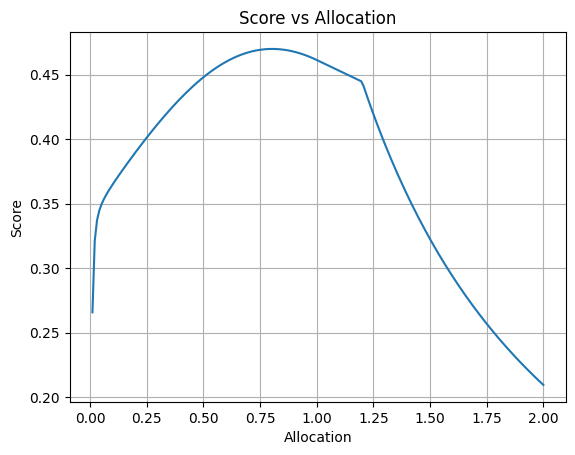

Best Allocation: 0.8040201005025126, Best Score: 0.46991930276382937


In [72]:
res = []

allocation_range = np.linspace(0, 2, 200)[1:] # 0-2の範囲で200分割
for allocation in allocation_range:
    # すべて同じallocationを割り当てた場合の最終スコアを計算
    submission = pd.DataFrame({'prediction': np.ones(len(train)) * allocation}, index=train.index)

    res_tmp, _ = score(train.copy(), submission, '',intermediate_res=[])
    res.append(res_tmp)

display("Score of allocations:")
# 図示
import matplotlib.pyplot as plt
plt.plot(allocation_range, res)
plt.xlabel("Allocation")
plt.ylabel("Score")
plt.title("Score vs Allocation")
plt.grid()
plt.show()
best_allocation = allocation_range[np.argmax(res)]
best_score = np.max(res)
print(f"Best Allocation: {best_allocation}, Best Score: {best_score}")

In [73]:
# 真値をそのままscoreに渡した場合
train['prediction'] = convert_ret_to_signal(
    train['forward_returns'].values,
    ret_signal_params
)
submission = pd.DataFrame({'prediction': train['prediction']}, index=train.index)
res_true, _ = score(train.copy(), submission, '',intermediate_res=[])
print(f"Score of true target allocation: {res_true}")

Score of true target allocation: 1.709709862551098


In [74]:
def _rolling_vol_no_leak(fr: pd.Series, window_size: int) -> np.ndarray:
    # 過去のみ参照（center=False）。窓不足の序盤は expanding std で埋める（未来は使わない）
    roll = fr.rolling(window=window_size, min_periods=window_size, center=False).std()
    # 序盤: 窓不足部分（NaN）を expanding std で補う（過去のみ）
    expd = fr.expanding(min_periods=2).std()  # 1点ではstdはNaNのまま
    vol = roll.combine_first(expd).bfill(limit=0)  # bfill(limit=0) 実質何もしない（安全のため残す）
    return vol.to_numpy()

def _ewma_vol_series(fr: pd.Series, lam: float = 0.94, min_periods: int = 2) -> np.ndarray:
    # EWMA分散 → 平方根でボラ。adjust=False で再帰形（オンライン更新と等価）
    var = (fr**2).ewm(alpha=1 - lam, adjust=False, min_periods=min_periods).mean()
    return np.sqrt(var).to_numpy()

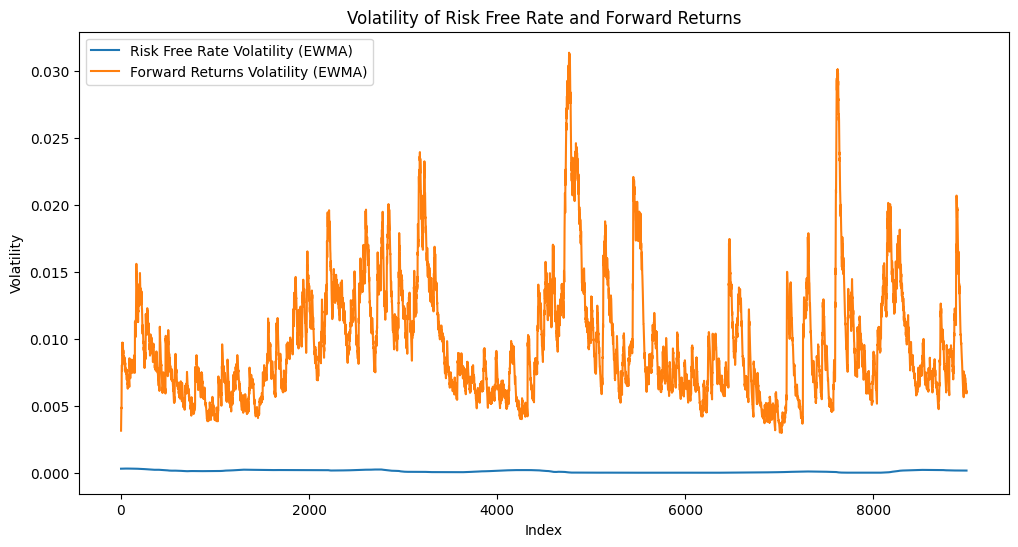

In [75]:
# train['risk_free_rate'], train['forward_returns']のボラティリティを計算し，プロットする

free_risk_vol = _ewma_vol_series(train['risk_free_rate'], lam=0.94, min_periods=2)
forward_returns_vol = _ewma_vol_series(train['forward_returns'], lam=0.94, min_periods=2)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(free_risk_vol, label='Risk Free Rate Volatility (EWMA)')
plt.plot(forward_returns_vol, label='Forward Returns Volatility (EWMA)')
plt.title('Volatility of Risk Free Rate and Forward Returns')
plt.xlabel('Index')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [76]:
# replaceライブラリをインポート
from replace import replace
#HTMLのインポート
from IPython.display import HTML, display

In [77]:
# 目的変数を編集することで，scoreをより高くできるか試す

# case 1: 真値をそのままscoreに渡した場合
# r: forward_returns（実現値）をそのまま使う＝完全予知の前提
r = train['forward_returns'].to_numpy()

m_grid = np.linspace(0.1, 10.0, 200)  # ここは状況に応じて広げる/狭める
best = (-np.inf, None)

for m in m_grid:
    signal_multiplier=m
    pred = convert_ret_to_signal(r, replace(ret_signal_params, signal_multiplier))
    submission = pd.DataFrame({'prediction': pred})
    s, _ = score(train[['forward_returns','risk_free_rate']].copy().reset_index(drop=True),
                 submission.reset_index(drop=True), '', [])
    if s > best[0]:
        best = (s, m)

best_score, best_m = best
print(f"[Oracle-linear] best_m={best_m:.4f}, score={best_score:.6f}")

[Oracle-linear] best_m=0.1000, score=1.709710


In [78]:
p = np.where(r > 0, 2.0, 0.0)  # 上限下限に張り付く極端な戦略
submission = pd.DataFrame({'prediction': p})
s_sign, _ = score(train[['forward_returns','risk_free_rate']].copy().reset_index(drop=True),
                  submission.reset_index(drop=True), '', [])
print(f"[Oracle-sign] score={s_sign:.6f}")

[Oracle-sign] score=9.735699


In [79]:
sigma_daily = _ewma_vol_series(train['forward_returns'])
sigma_ann = sigma_daily * np.sqrt(252)
# 2) 市場水準に合わせた目標ボラ（ペナルティ閾値1.2と整合させるのがコツ）
sigma_ref = np.nanmedian(sigma_ann)
for gamma in np.linspace(0.8, 1.2, 9):  # 目標ボラ = gamma * 市場年率ボラ
    ell = np.minimum(2.0, (gamma*sigma_ref) / (sigma_ann + 1e-6))
    pred = convert_ret_to_signal(r, ret_signal_params, signal_multiplier=ell)
    s, _ = score(train[['forward_returns','risk_free_rate']].copy().reset_index(drop=True),
                 pd.DataFrame({'prediction': pred}), '', [])

In [80]:
s

0.6034273757111422

In [81]:
def clip_stats(signal):
    s = np.asarray(signal)
    return (np.mean(s<=0.0), np.mean(s>=2.0))

def _ewma_sigma(fr: pd.Series, lam: float = 0.94, min_periods: int = 5) -> np.ndarray:
    """
    日次ボラ σ_t（非年率）。過去のみ参照（adjust=False）。
    """
    var = (fr**2).ewm(alpha=1 - lam, adjust=False, min_periods=min_periods).mean()
    sig = np.sqrt(var.to_numpy())
    # 極小ボラ対策（序盤の過小推定を抑制）
    if np.isfinite(sig).any():
        floor = max(np.percentile(sig[np.isfinite(sig)], 5), 1e-6)
        sig = np.maximum(sig, floor)
    return sig

def _oracle_score_from_signal(signal: np.ndarray) -> float:
    """
    予測シグナル（0~2）を score() に流して評価スコアを返す。
    """
    sol = train[['forward_returns','risk_free_rate']].reset_index(drop=True)
    sub = pd.DataFrame({'prediction': signal}).reset_index(drop=True)
    s, _ = score(sol.copy(), sub, '', intermediate_res=[])
    return float(s)

# =====================================
#   共通: ランダム誤差を注入する関数
# =====================================
def inject_random_noise(signal: np.ndarray, accuracy_ratio: float, seed: int = 42) -> np.ndarray:
    """
    Injects random noise into a given signal to simulate imperfect prediction accuracy.

    Args:
        signal (np.ndarray): Original oracle signal (0~2 range)
        accuracy_ratio (float): Fraction of samples that remain correct (0~1)
        seed (int): Random seed for reproducibility

    Returns:
        np.ndarray: Partially randomized signal
    """
    rng = np.random.default_rng(seed)
    n = len(signal)
    n_corrupt = int(n * (1 - accuracy_ratio))
    idx = rng.choice(n, size=n_corrupt, replace=False)

    # Replace selected indices with random positions between 0~2
    noisy_signal = signal.copy()
    noisy_signal[idx] = rng.uniform(0.0, 2.0, size=n_corrupt)
    return noisy_signal


# =====================================
#   A/B/C オラクルに精度シミュレーションを組み込み
# =====================================

def oracle_A_vol_normalized_sim(accuracy_ratio: float = 1.0, lam: float = 0.94,
                                m_grid=None, seed: int = 42) -> tuple[float, float]:
    fr = train['forward_returns']
    sigma_t = _ewma_sigma(fr, lam=lam, min_periods=5)
    y_star = fr.to_numpy() / sigma_t
    if m_grid is None:
        m_grid = np.linspace(0.1, 5.0, 40)
    best_s, best_m = -np.inf, None
    for m in m_grid:
        pred = convert_ret_to_signal(y_star, ret_signal_params, signal_multiplier=m)
        pred_noisy = inject_random_noise(pred, accuracy_ratio, seed)
        s = _oracle_score_from_signal(pred_noisy)
        if s > best_s:
            best_s, best_m = s, float(m)
    return best_s, best_m

def oracle_B_zscore_sim(accuracy_ratio: float = 1.0,
                        lam_sigma: float = 0.94, lam_mu: float = 0.05,
                        m_grid=None, seed: int = 42) -> tuple[float, float]:
    fr = train['forward_returns']
    mu_t = fr.ewm(alpha=lam_mu, adjust=False, min_periods=5).mean().to_numpy()
    sigma_t = _ewma_sigma(fr, lam=lam_sigma, min_periods=5)
    y_star = (fr.to_numpy() - mu_t) / sigma_t
    if m_grid is None:
        m_grid = np.linspace(0.1, 5.0, 40)
    best_s, best_m = -np.inf, None
    for m in m_grid:
        pred = convert_ret_to_signal(y_star, ret_signal_params, signal_multiplier=m)
        pred_noisy = inject_random_noise(pred, accuracy_ratio, seed)
        s = _oracle_score_from_signal(pred_noisy)
        if s > best_s:
            best_s, best_m = s, float(m)
    return best_s, best_m

def oracle_C_vol_targeted_sim(accuracy_ratio: float = 1.0, lam: float = 0.94,
                              gamma_grid=None, k_grid=None, seed: int = 42) -> tuple[float, float, float]:
    fr = train['forward_returns']
    sigma_daily = _ewma_sigma(fr, lam=lam, min_periods=5)
    sigma_ann = sigma_daily * np.sqrt(252.0)
    sigma_ref = np.nanmedian(sigma_ann)
    if gamma_grid is None:
        gamma_grid = np.linspace(0.8, 1.2, 9)
    if k_grid is None:
        k_grid = np.linspace(0.2, 3.0, 20)
    best_s, best_gamma, best_k = -np.inf, None, None
    for gamma in gamma_grid:
        denom = np.maximum(sigma_ann, 1e-6) / gamma
        core = fr.to_numpy() / denom
        for k in k_grid:
            p = np.clip(1.0 + k * core, 0.0, 2.0)
            p_noisy = inject_random_noise(p, accuracy_ratio, seed)
            s = _oracle_score_from_signal(p_noisy)
            if s > best_s:
                best_s, best_gamma, best_k = s, float(gamma), float(k)
    return best_s, best_gamma, best_k

# =====================================
#   実験ユーティリティ
# =====================================

def run_oracle_simulations(acc_list=(1.0, 0.9, 0.8, 0.7, 0.5, 0.3)):
    """
    各accuracy_ratioに対して A/B/C のscoreを出力。
    """
    results = []
    for acc in acc_list:
        sA, mA = oracle_A_vol_normalized_sim(acc)
        sB, mB = oracle_B_zscore_sim(acc)
        sC, gC, kC = oracle_C_vol_targeted_sim(acc)
        results.append({
            'accuracy': acc,
            'A_score': sA, 'A_m': mA,
            'B_score': sB, 'B_m': mB,
            'C_score': sC, 'C_gamma': gC, 'C_k': kC
        })
        print(f"accuracy={acc:.2f} | A={sA:.3f}  B={sB:.3f}  C={sC:.3f}")
    return pd.DataFrame(results)


In [82]:
results = run_oracle_simulations()
display(results)

accuracy=1.00 | A=9.606  B=9.434  C=3.545
accuracy=0.90 | A=8.538  B=8.396  C=3.233
accuracy=0.80 | A=7.189  B=7.080  C=2.671
accuracy=0.70 | A=6.523  B=6.434  C=2.511
accuracy=0.50 | A=4.832  B=4.769  C=1.895
accuracy=0.30 | A=3.129  B=3.095  C=1.293


,accuracy,A_score,A_m,B_score,B_m,C_score,C_gamma,C_k
0,1.0,9.606094,5.0,9.433746,5.0,3.544662,1.2,3.0
1,0.9,8.538371,5.0,8.395725,5.0,3.233332,1.2,3.0
2,0.8,7.188845,5.0,7.079706,5.0,2.670839,1.2,3.0
3,0.7,6.523031,5.0,6.433597,5.0,2.510779,1.2,3.0
4,0.5,4.831994,5.0,4.769146,5.0,1.895489,1.2,3.0
5,0.3,3.128584,5.0,3.094875,5.0,1.293468,1.2,3.0


In [83]:
# inject_random_noiseを上書き -> 別動作で検証
def inject_random_noise(signal, accuracy_ratio, seed=42):
    rng = np.random.default_rng(seed)
    s = signal.copy()
    n = len(s); k = int(n * (1 - accuracy_ratio))
    idx = rng.choice(n, size=k, replace=False)
    # 0↔2 の反転（1は中立はそのまま）
    s[idx] = np.where(s[idx] < 1.0, 2.0, 0.0)
    return s

In [84]:
results = run_oracle_simulations()
display(results)

accuracy=1.00 | A=9.606  B=9.434  C=3.545
accuracy=0.90 | A=6.795  B=6.692  C=2.010
accuracy=0.80 | A=4.614  B=4.557  C=0.582
accuracy=0.70 | A=2.968  B=2.940  C=-0.079
accuracy=0.50 | A=0.265  B=0.263  C=-0.049
accuracy=0.30 | A=-0.036  B=-0.036  C=-0.035


,accuracy,A_score,A_m,B_score,B_m,C_score,C_gamma,C_k
0,1.0,9.606094,5.0,9.433746,5.0,3.544662,1.2,3.0
1,0.9,6.794601,5.0,6.692049,5.0,2.009679,1.2,3.0
2,0.8,4.614439,5.0,4.557308,5.0,0.582481,1.2,3.0
3,0.7,2.968277,5.0,2.940190,5.0,-0.079454,0.8,0.2
4,0.5,0.265478,5.0,0.263048,5.0,-0.049222,0.8,0.2
5,0.3,-0.035509,0.1,-0.035718,0.1,-0.034541,0.8,0.2
